# MNIST letter recognition

## About the model `NumberClassifier`

Convolutional Neural Network (CNN) is used to classify images. Specifically,  TinyVGG architecture is used since the input size of the image is quite small (32x32.

TinyVGG's single block contains
* `Conv2d`
* `ReLU`
* `Conv2d`
* `ReLU`
* `MaxPool2d`

The kernel size is set to 2, stride and padding are set to 1 for both convolution and pooling layers.

A classifier layer conatins
* `Flatten`
* `Linear`

Combining 2 blocks and a classifier sequentially completes a forward pass.

## Model Training and Testing

60000 training images are separated into 1875 batches with 32 images, and 10000 test images independent from training dataset is used for model evaluation.

`CrossEntropyLoss()` loss function is used for calculating the loss, and `SGD` optimizer is used to train the model. Since the model returns logits for multiclass classification problem, they are converted into a prediction probability list using `softmax` activation function. Then, taking `.argmax()` method returns the index of the greatest number in maximum probability list, which directly corresponds to the prediction.

## Model Performance

The model is trained using a T4 GPU (Tesla T4) with 15360Mib memory and 70W power cap is used along with CUDA 12.2.

Training for 7 epochs takes about 77 seconds (11 seconds per epoch) on average and evaluation metrics gives about 96%-97% accuracy with learning rate 0.05 in `SGD` optimizer.

In [29]:
!nvidia-smi

Sat Jan 20 05:16:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    207MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Testing model before training...


100%|██████████| 10000/10000 [00:06<00:00, 1456.56it/s]



ACCURACY: 10.10%

-------
EPOCH 0
-------
Training using 1875 image batches...


100%|██████████| 1875/1875 [00:11<00:00, 168.83it/s]


Training loss: 2.2998545169830322
Testing 10000 images...


100%|██████████| 10000/10000 [00:07<00:00, 1307.62it/s]



ACCURACY: 11.40%

-------
EPOCH 1
-------
Training using 1875 image batches...


100%|██████████| 1875/1875 [00:11<00:00, 157.82it/s]


Training loss: 1.1881732940673828
Testing 10000 images...


100%|██████████| 10000/10000 [00:06<00:00, 1442.06it/s]



ACCURACY: 88.09%

-------
EPOCH 2
-------
Training using 1875 image batches...


100%|██████████| 1875/1875 [00:11<00:00, 168.90it/s]


Training loss: 0.38304364681243896
Testing 10000 images...


100%|██████████| 10000/10000 [00:07<00:00, 1364.83it/s]



ACCURACY: 90.36%

-------
EPOCH 3
-------
Training using 1875 image batches...


100%|██████████| 1875/1875 [00:11<00:00, 164.59it/s]


Training loss: 0.3161342442035675
Testing 10000 images...


100%|██████████| 10000/10000 [00:06<00:00, 1493.74it/s]



ACCURACY: 92.47%

-------
EPOCH 4
-------
Training using 1875 image batches...


100%|██████████| 1875/1875 [00:11<00:00, 166.57it/s]


Training loss: 0.22791559994220734
Testing 10000 images...


100%|██████████| 10000/10000 [00:07<00:00, 1377.92it/s]



ACCURACY: 95.19%

-------
EPOCH 5
-------
Training using 1875 image batches...


100%|██████████| 1875/1875 [00:11<00:00, 165.75it/s]


Training loss: 0.1596992462873459
Testing 10000 images...


100%|██████████| 10000/10000 [00:06<00:00, 1498.82it/s]



ACCURACY: 95.87%

-------
EPOCH 6
-------
Training using 1875 image batches...


100%|██████████| 1875/1875 [00:11<00:00, 166.98it/s]


Training loss: 0.12734679877758026
Testing 10000 images...


100%|██████████| 10000/10000 [00:08<00:00, 1236.16it/s]



ACCURACY: 96.30%



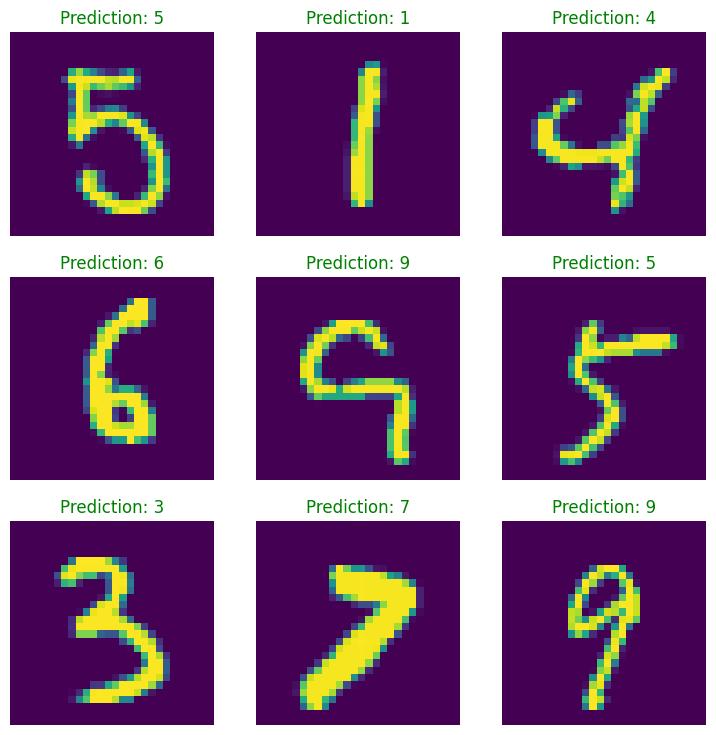

In [30]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

## Visualizing 9 random images ##
def show_9_images():

  test_samples = []
  test_labels = []
  for i in range(9):
    n = random.randrange(500)
    img, label = test_data[n]
    test_samples.append(img)
    test_labels.append(label)

  plt.figure(figsize = (9,9))
  nrows = 3
  ncols = 3
  for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.permute(1,2,0))

    with torch.inference_mode():
      sample = sample.unsqueeze(dim=0).to(device)
      logit = NumberClassifier(sample)
      pred_probs = torch.softmax(logit.squeeze(), dim=0)
      y_pred = pred_probs.argmax()
    y_true = test_labels[i]

    title_text = f"Prediction: {y_pred}"

    if y_pred == y_true:
      plt.title(title_text, c="g")
    else:
      plt.title(title_text, c="r")
    plt.axis(False)


## Creating training and test datasets ##

train_data = torchvision.datasets.MNIST(root = "data",
                                        train = True,
                                        transform = torchvision.transforms.ToTensor(),
                                        download = True)

test_data = torchvision.datasets.MNIST(root = "data",
                                       train = False,
                                       transform = torchvision.transforms.ToTensor(),
                                       download = True)

number_lst = train_data.classes

## Creating MNISTModel ##

class MNISTModel(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*8*8,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

NumberClassifier = MNISTModel(input_shape = 1, output_shape = len(number_lst), hidden_units = 10).to(device)

## Testing before training ##
NumberClassifier.eval()
y_trues = []
y_preds = []
with torch.inference_mode():
  print(f"Testing model before training...")
  for i in tqdm(range(len(test_data))):
    img, label = test_data[i]
    y_logit = NumberClassifier(img.unsqueeze(dim=0).to(device))
    y_pred_probs = torch.softmax(y_logit.squeeze(), dim=0)
    y_pred = y_pred_probs.argmax()
    y_preds.append(y_pred)
    y_trues.append(label)

cnt = 0
for i in range(len(y_trues)):
  if y_trues[i] == y_preds[i]:
    cnt += 1
print(f"\nACCURACY: {cnt*100/len(y_trues):.2f}%\n")


## Training Step ##

train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = False)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(NumberClassifier.parameters(), lr = 0.005)

epochs = 7

for epoch in range(epochs):
  NumberClassifier.train()
  train_loss=0
  print(f"-------\nEPOCH {epoch}\n-------")
  print(f"Training using {len(train_dataloader)} image batches...")
  for (X,y) in tqdm(train_dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = NumberClassifier(X)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss
  print(f"Training loss: {train_loss/len(train_dataloader)}")


  NumberClassifier.eval()
  y_trues = []
  y_preds = []
  with torch.inference_mode():
    print(f"Testing {len(test_data)} images...")
    for i in tqdm(range(len(test_data))):
      img, label = test_data[i]
      y_logit = NumberClassifier(img.unsqueeze(dim=0).to(device))
      y_pred_probs = torch.softmax(y_logit.squeeze(), dim=0)
      y_pred = y_pred_probs.argmax()
      y_preds.append(y_pred)
      y_trues.append(label)

  cnt = 0
  for i in range(len(y_trues)):
    if y_trues[i] == y_preds[i]:
      cnt += 1
  print(f"\nACCURACY: {cnt*100/len(y_trues):.2f}%\n")

show_9_images()